## Import packages

In [1]:
import pandas as pd
import numpy as np
#from google.colab import drive
import numpy

%pip install tf-explain tensorflow==2.2.0
from tensorflow.keras.preprocessing import image
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
%matplotlib inline
import cProfile
from tensorflow import keras 
import tensorflow
from tensorflow.keras.preprocessing import image

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D, Dense , BatchNormalization, Dropout, Conv2D, MaxPooling2D,Activation,Flatten
from tensorflow.keras import backend
import random

from tf_explain.utils.display import image_to_uint_255
import cv2

from tensorflow.keras.datasets import fashion_mnist
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Datasets

In [ ]:
# FGVC Aircraft (NEVER RUN THESE AGAIN 
# !wget https://data.deepai.org/FGVCAircraft.zip -P /content/drive/MyDrive/FGVC_Aircraft

In [ ]:
# (NEVER RUN THESE AGAIN @ JOSH ALEEN)

In [ ]:
# Stanford cars (NEVER RUN THESE AGAIN
# !wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz -P /content/drive/MyDrive/Stanford_Cars
# !wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz -P /content/drive/MyDrive/Stanford_Cars

--2021-11-14 13:47:48--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/Stanford_Cars/cars_test.tgz.1’

cars_test.tgz.1     100%[===================>] 932.07M  13.5MB/s    in 67s     

2021-11-14 13:48:56 (13.8 MB/s) - ‘/content/drive/MyDrive/Stanford_Cars/cars_test.tgz.1’ saved [977350468/977350468]



In [ ]:
#(NEVER RUN THESE AGAIN
# !tar -xvf /content/drive/MyDrive/Stanford_Cars/cars_train.tgz -C /content/drive/MyDrive
# !tar -xvf /content/drive/MyDrive/Stanford_Cars/cars_test.tgz -C /content/drive/MyDrive

In [ ]:
# # Fashion MNIST
# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# # Stanford Dogs
# trainDataset, testDataset = tfds.load(name='stanford_dogs', split=['train', 'test'], as_supervised=True)

# Standford Cars
# trainDataset_cars, testDataset_cars = tfds.load(name='cars196', split=['train', 'test'], as_supervised=True)

# FGVC Aircraft (consider not doing)
#!wget https://data.deepai.org/FGVCAircraft.zip


4423680/4422102 [==============================] - 0s 0us/step


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE6UHGP/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE6UHGP/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Model Helper Functions

In [3]:
def custom_get_gradients_and_filters(
    model, images, layer_name, class_index, use_guided_grads
):
    """
    Generate guided gradients and convolutional outputs with an inference.
    Args:
        model (tf.keras.Model): tf.keras model to inspect
        images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
        layer_name (str): Targeted layer for GradCAM
        class_index (int): Index of targeted class
        use_guided_grads (boolean): Whether to use guided grads or raw gradients
    Returns:
        Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
    """
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tensorflow.GradientTape() as tape:
        inputs = tensorflow.cast(images, tensorflow.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    if use_guided_grads:
        grads = (
            tensorflow.cast(conv_outputs > 0, "float32")
            * tensorflow.cast(grads > 0, "float32")
            * grads
        )

    return conv_outputs, grads

In [4]:
def apply_heatmap_occlusion(
    heatmap, original_image, THRESHOLD=0.85
):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply occlusion
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

    super_threshold_indices = (heatmap>THRESHOLD)

    output = original_image
    output[super_threshold_indices] = 0.0
    return output

In [5]:
def batch_gradCAM_augmentationn(images,y_matrix,model, layer_name = 'mixed10'):
  contador = 0
  explainer = GradCAM()
  images_mod = images.numpy()

  for i in range(0,tensorflow.shape(images_mod)[0]):

    
    class_index = tensorflow.argmax(y_matrix[i])

    outputs, grads = custom_get_gradients_and_filters(
        model, np.expand_dims(images_mod[i], axis=0), layer_name, class_index, True
    )

    grid = explainer.explain((np.expand_dims(images_mod[i], axis=0),None), model, layer_name = layer_name, class_index= class_index)
    #explainer.save(grid, "./grad_cam_batch/", "heatmap_batch"+str(contador)+".jpg")
    cams = explainer.generate_ponderated_output(outputs, grads)
    heatmap = apply_heatmap_occlusion(cams[0].numpy(), images_mod[i])
    #explainer.save(image_to_uint_255(images_mod[i]), "./grad_cam_batch/", "original_batch"+str(contador)+".jpg")
    #explainer.save(image_to_uint_255(heatmap), "./grad_cam_batch/", "grad_cam_batch"+str(contador)+".jpg")
    #explainer.save(image_to_uint_255(images.numpy()[i]), "./grad_cam_batch/", "tensor"+str(contador)+".jpg")
    contador = contador+1
    #salvamos la imagen modificada
    images_mod[i]=heatmap
  images = tensorflow.convert_to_tensor(images_mod)
  return images,y_matrix

In [6]:
import tensorflow
class CustomModel(tensorflow.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        n_random=random.random()
        P_Occlusion = 0.25
        #tensorflow.print("augmentation "+ str(n_random))

        if(n_random<=P_Occlusion):
          x,y = batch_gradCAM_augmentationn(x,y,self)

        with tensorflow.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [7]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Begin Data Loading - Stanford Cars

In [8]:
cars_meta = loadmat('/content/drive/MyDrive/cars_annos.mat')
cars_train_annos = loadmat('/content/drive/MyDrive/cars_train_annos.mat')
cars_test_annos = loadmat('/content/drive/MyDrive/cars_test_annos.mat')
cars_test_class = pd.read_csv('/content/drive/MyDrive/anno_test.csv', header = None)

In [9]:
# Load Labels
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head(5)

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [10]:
# Keep only 50 classes
labels_to_keep = labels.iloc[:51, :].values.flatten()
labels_to_keep

array(['AM General Hummer SUV 2000', 'Acura RL Sedan 2012',
       'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
       'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
       'Acura ZDX Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012',
       'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008',
       'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012',
       'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994',
       'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011',
       'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012',
       'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007',
       'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012',
       'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012',
       'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012',
       'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007',
       'BMW X

In [11]:
# Load Training Annotations
train_path = Path('/content/drive/MyDrive/cars_train')
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [str(train_path/f) for f in df_train['fname']] #  Appending Path
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train[df_train['labels'] != 'AM General Hummer SUV 2000']
df_train = df_train.sort_index()

#Keep only 50 classes
df_train = df_train[df_train.labels.isin(labels_to_keep)]
df_train.reset_index(inplace=True)
df_train.head()

,index,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,0,39,116,569,375,13,/content/drive/MyDrive/cars_train/00001.jpg,Audi TTS Coupe 2012
1,1,36,116,868,587,2,/content/drive/MyDrive/cars_train/00002.jpg,Acura TL Sedan 2012
2,10,51,93,601,393,48,/content/drive/MyDrive/cars_train/00011.jpg,Buick Verano Sedan 2012
3,16,39,52,233,150,13,/content/drive/MyDrive/cars_train/00017.jpg,Audi TTS Coupe 2012
4,21,212,538,1893,1131,35,/content/drive/MyDrive/cars_train/00022.jpg,BMW M6 Convertible 2010


In [12]:
# Load Testing Annotations
test_path = Path('/content/drive/MyDrive/cars_test')
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [str(test_path/f) for f in df_test['fname']] #  Appending Path
df_test['class'] = cars_test_class[5]
df_test = df_test.merge(labels, left_on='class', right_index=True)
df_test = df_test.sort_index()

# Keep only 50 classes
df_test = df_test[df_test.labels.isin(labels_to_keep)]
df_test.reset_index(inplace=True)
df_test.head()

,index,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname,class,labels
0,8,1,7,275,183,/content/drive/MyDrive/cars_test/00009.jpg,32,BMW X6 SUV 2012
1,10,30,20,438,253,/content/drive/MyDrive/cars_test/00011.jpg,49,Buick Enclave SUV 2012
2,17,113,66,554,369,/content/drive/MyDrive/cars_test/00018.jpg,33,BMW M3 Coupe 2012
3,18,82,70,277,168,/content/drive/MyDrive/cars_test/00019.jpg,22,Audi S4 Sedan 2012
4,19,25,56,569,416,/content/drive/MyDrive/cars_test/00020.jpg,32,BMW X6 SUV 2012


### Visualize Images

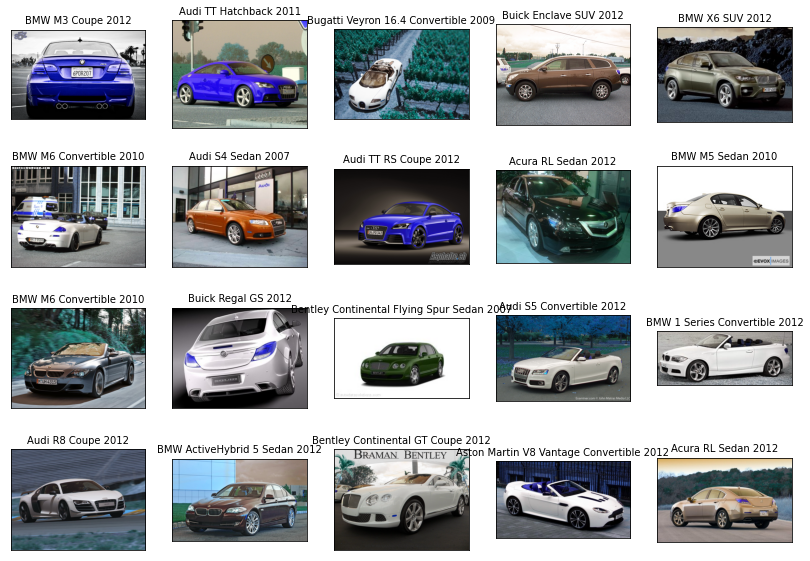

In [13]:
plt.figure(figsize = (14,10))
for i in range(20):
    random1 = np.random.randint(1,len(df_train))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(str(df_train.loc[random1,"fname"])))
    plt.title(df_train.loc[random1, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Train data gen

In [18]:
target_size=(224,224)
batch_size=64

In [19]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(df_train, x_col='fname', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(df_test,  x_col='fname', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 2035 validated image filenames belonging to 50 classes.
Found 2010 validated image filenames belonging to 50 classes.


## Begin Model

In [24]:
# Instantiate model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import vgg16
img_height,img_width = 224,224
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
x = BatchNormalization()(inceptionV3.output)
x = Activation('relu')(x)
#x = AveragePooling2D(pool_size=3)(x)
x = Flatten()(x)
n_classes = 50
output = Dense(n_classes, activation='softmax', name="prediction_layer")(x)
model = CustomModel(inputs=[inceptionV3.input], outputs = output)

In [ ]:
# confirm model architecture
print(model)

In [25]:
#tf.executing_eagerly()
import numpy

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50,  verbose=1, mode='min')
callbacks_list = [earlystop]
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['acc',f1_m,precision_m, recall_m])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=50 , validation_data=test_gen, callbacks=callbacks_list)

# model.fit(train_gen, batch_size=64, epochs=250,)# validation_data=(X_test, y_test))
model.save('/content/drive/MyDrive/base_model_50epochsB.h5')

Epoch 1/50
32/32 [==============================] - 446s 14s/step - loss: 8.4590 - acc: 0.0229 - f1_m: 0.0055 - precision_m: 0.0064 - recall_m: 0.0049 - val_loss: 184129952.0000 - val_acc: 0.0209 - val_f1_m: 0.0205 - val_precision_m: 0.0205 - val_recall_m: 0.0205
Epoch 2/50
32/32 [==============================] - 39s 1s/step - loss: 5.3095 - acc: 0.0209 - f1_m: 9.6154e-04 - precision_m: 0.0312 - recall_m: 4.8828e-04 - val_loss: 973924.6875 - val_acc: 0.0254 - val_f1_m: 0.0244 - val_precision_m: 0.0252 - val_recall_m: 0.0237
Epoch 3/50
32/32 [==============================] - 39s 1s/step - loss: 4.7179 - acc: 0.0144 - f1_m: 0.0019 - precision_m: 0.0312 - recall_m: 9.7656e-04 - val_loss: 55837008.0000 - val_acc: 0.0209 - val_f1_m: 0.0212 - val_precision_m: 0.0212 - val_recall_m: 0.0212
Epoch 4/50
32/32 [==============================] - 38s 1s/step - loss: 5.0605 - acc: 0.0159 - f1_m: 9.6154e-04 - precision_m: 0.0312 - recall_m: 4.8828e-04 - val_loss: 308920640.0000 - val_acc: 0.0209 - 

In [29]:
res = pd.DataFrame(model.history.history)
# res.to_csv('/content/drive/MyDrive/expt_results/cars_expt_50epochs_withcallbacks.csv')

In [30]:
# Add another 50 trains
model.fit(train_gen, batch_size=64, epochs=50 , validation_data=test_gen, callbacks=callbacks_list)

# model.fit(train_gen, batch_size=64, epochs=250,)# validation_data=(X_test, y_test))
model.save('/content/drive/MyDrive/cars_base_model_100epochs.h5')

Epoch 1/50
32/32 [==============================] - 40s 1s/step - loss: 2.2827 - acc: 0.4821 - f1_m: 0.3849 - precision_m: 0.7100 - recall_m: 0.2677 - val_loss: 87.2598 - val_acc: 0.2144 - val_f1_m: 0.0162 - val_precision_m: 0.1234 - val_recall_m: 0.0088
Epoch 2/50
32/32 [==============================] - 40s 1s/step - loss: 1.7954 - acc: 0.5443 - f1_m: 0.4389 - precision_m: 0.7534 - recall_m: 0.3116 - val_loss: 8.0403 - val_acc: 0.2498 - val_f1_m: 0.0265 - val_precision_m: 0.3604 - val_recall_m: 0.0139
Epoch 3/50
32/32 [==============================] - 39s 1s/step - loss: 1.6146 - acc: 0.5930 - f1_m: 0.5309 - precision_m: 0.7702 - recall_m: 0.4066 - val_loss: 10.2951 - val_acc: 0.4109 - val_f1_m: 0.1060 - val_precision_m: 0.5802 - val_recall_m: 0.0592
Epoch 4/50
32/32 [==============================] - 39s 1s/step - loss: 1.5918 - acc: 0.6294 - f1_m: 0.5676 - precision_m: 0.7994 - recall_m: 0.4417 - val_loss: 11.7159 - val_acc: 0.3632 - val_f1_m: 0.1516 - val_precision_m: 0.6887 - va

In [31]:
res = pd.DataFrame(model.history.history)
# res.to_csv('/content/drive/MyDrive/expt_results/cars_expt_50epochs_withcallbacks2.csv')

## TL Switch

In [20]:
# Instantiate model VGG (2nd pass ResNet50)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
img_height,img_width = 224,224
vgg16 = ResNet50(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
x = BatchNormalization()(vgg16.output)
x = Activation('relu')(x)
#x = AveragePooling2D(pool_size=3)(x)
x = Flatten()(x)
n_classes = 50
output = Dense(n_classes, activation='softmax', name="prediction_layer")(x)
model = CustomModel(inputs=[vgg16.input], outputs = output)

In [21]:
#tf.executing_eagerly()
import numpy

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50,  verbose=1, mode='min')
callbacks_list = [earlystop]
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['acc',f1_m,precision_m, recall_m])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=50 , validation_data=test_gen, callbacks=callbacks_list)

# model.fit(train_gen, batch_size=64, epochs=250,)# validation_data=(X_test, y_test))
model.save('/content/drive/MyDrive/cars_base_model_50epochs_resnet50.h5')

Epoch 1/50
32/32 [==============================] - 41s 1s/step - loss: 10.5329 - acc: 0.0303 - f1_m: 0.0126 - precision_m: 0.0256 - recall_m: 0.0093 - val_loss: 24879.3887 - val_acc: 0.0169 - val_f1_m: 0.0173 - val_precision_m: 0.0173 - val_recall_m: 0.0173
Epoch 2/50
32/32 [==============================] - 40s 1s/step - loss: 9.4156 - acc: 0.0637 - f1_m: 0.0153 - precision_m: 0.0559 - recall_m: 0.0093 - val_loss: 181519504.0000 - val_acc: 0.0199 - val_f1_m: 0.0210 - val_precision_m: 0.0210 - val_recall_m: 0.0210
Epoch 3/50
32/32 [==============================] - 40s 1s/step - loss: 7.8790 - acc: 0.1930 - f1_m: 0.0495 - precision_m: 0.2448 - recall_m: 0.0278 - val_loss: 1085.3833 - val_acc: 0.0199 - val_f1_m: 0.0195 - val_precision_m: 0.0195 - val_recall_m: 0.0195
Epoch 4/50
32/32 [==============================] - 40s 1s/step - loss: 8.2739 - acc: 0.3438 - f1_m: 0.0851 - precision_m: 0.4390 - recall_m: 0.0476 - val_loss: 11.3492 - val_acc: 0.0169 - val_f1_m: 0.0096 - val_precision_

In [22]:
res = pd.DataFrame(model.history.history)
# res.to_csv('/content/drive/MyDrive/expt_results/cars_expt_50epochs_withresnet50.csv')

# New Section

In [ ]:
import numpy
tf.executing_eagerly()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=100, validation_data=train_gen)
model.save('/content/drive/MyDrive/base_model_100epochstrain.h5')

Epoch 1/100
127/127 [==============================] - 1457s 11s/step - loss: 7.2021 - accuracy: 0.0049 - val_loss: 34.0401 - val_accuracy: 0.0051
Epoch 2/100
127/127 [==============================] - 299s 2s/step - loss: 5.8185 - accuracy: 0.0058 - val_loss: 1030.0344 - val_accuracy: 0.0056
Epoch 3/100
127/127 [==============================] - 297s 2s/step - loss: 5.6561 - accuracy: 0.0084 - val_loss: 5.2977 - val_accuracy: 0.0053
Epoch 4/100
127/127 [==============================] - 296s 2s/step - loss: 5.5723 - accuracy: 0.0079 - val_loss: 443.7414 - val_accuracy: 0.0041
Epoch 5/100
127/127 [==============================] - 297s 2s/step - loss: 5.4044 - accuracy: 0.0093 - val_loss: 7.7765 - val_accuracy: 0.0084
Epoch 6/100
127/127 [==============================] - 297s 2s/step - loss: 5.3903 - accuracy: 0.0099 - val_loss: 45.3700 - val_accuracy: 0.0048
Epoch 7/100
127/127 [==============================] - 298s 2s/step - loss: 5.3360 - accuracy: 0.0099 - val_loss: 7.1669 - val_

In [ ]:
import numpy
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=160)
model.save('base_model_250epochs3.h5')
model.save('/content/drive/MyDrive/base_model_250epochs.h5')

NameError: ignored

In [ ]:
# Fixed LOOK AT THE FILE PATH this is how you save to drive
model.save('/content/drive/MyDrive/base_model_250epochs.h5')

NameError: ignored